<a href="https://colab.research.google.com/github/alloysArtifexLabs/IMAGE-AI/blob/image-classifier/Urban_vs_Rural_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import cv2

In [3]:
#Load the EuroSAT Dataset
(ds_train, ds_val), ds_info = tfds.load(
    'eurosat',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True,
)
label_names = ds_info.features['label'].names
print("Original classes:", label_names)

Original classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [4]:
#Map Original Labels to Binary(Urban vs Rural)
URBAN_CLASSES = ['Residential', 'Industrial', 'Highway']
urban_indices = [label_names.index(c) for c in URBAN_CLASSES]
urban_tensor = tf.constant(urban_indices, dtype=tf.int64)

def map_to_binary(image, label):
  """
  Convert the original 10-class label to binary:
  0 -> Urban (if label in URBAN_CLASSES)
  1 -> Rural (otherwise)
  """
  is_urban = tf.reduce_any(tf.equal(label, urban_tensor))
  new_label = tf.cast(tf.logical_not(is_urban), tf.int32)
  return image, new_label

ds_train = ds_train.map(map_to_binary,num_parallel_calls=tf.data.AUTOTUNE)
ds_val   = ds_val.map(map_to_binary,num_parallel_calls=tf.data.AUTOTUNE)




In [5]:
#Preprocess Images
IMG_SIZE = 224

def preprocess(image,label):
  image = tf.image.resize(image,(IMG_SIZE, IMG_SIZE))
  image = tf.cast(image, tf.float32) / 255.0
  return image, label

ds_train = ds_train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_val   = ds_val.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)


In [6]:
#Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomContrast(0.1)
])

def augment(image, label):
    # Expand dims to add the batch dimension (making shape (1, 224, 224, 3))
    image = tf.expand_dims(image, axis=0)
    image = data_augmentation(image, training=True)
    # Squeeze the batch dimension back out (returning to shape (224, 224, 3))
    image = tf.squeeze(image, axis=0)
    return image, label


In [9]:
#Batch and Prefetch the Data
BATCH_SIZE = 32

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomContrast(0.1)
])

def augment(image, label):
  image = tf.expand_dims(image, axis=0)
  image = data_augmentation(image, training=True)
  image = tf.squeeze(image, axis=0)
  return image, label

ds_train = ds_train.map(augment, num_parallel_calls=tf.data.AUTOTUNE)


ds_train = ds_train.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_val   = ds_val.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [11]:
#Build Model with Transfer Learning
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(2,activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │           2,562 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
#Compile the Model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)


In [14]:
#Train the Model
EPOCHS = 10
history = model.fit(ds_train, validation_data=ds_val, epochs=EPOCHS)

Epoch 1/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 169s 240ms/step - accuracy: 0.7660 - loss: 0.5195 - val_accuracy: 0.7730 - val_loss: 0.4756
Epoch 2/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 202s 240ms/step - accuracy: 0.7814 - loss: 0.4927 - val_accuracy: 0.7896 - val_loss: 0.4561
Epoch 3/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 203s 242ms/step - accuracy: 0.7926 - loss: 0.4772 - val_accuracy: 0.8093 - val_loss: 0.4400
Epoch 4/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 202s 243ms/step - accuracy: 0.7931 - loss: 0.4711 - val_accuracy: 0.8061 - val_loss: 0.4301
Epoch 5/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 169s 241ms/step - accuracy: 0.8005 - loss: 0.4565 - val_accuracy: 0.7870 - val_loss: 0.4446
Epoch 6/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 202s 240ms/step - accuracy: 0.8020 - loss: 0.4590 - val_accuracy: 0.8094 - val_loss: 0.4166
Epoch 7/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 168s 240ms/step - accuracy: 0.8090 - loss: 0.4465 - val_accuracy: 0.8031 - val_loss: 0.4181
Epoch 8/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 170s 242ms/step - accuracy: 0.8094 -

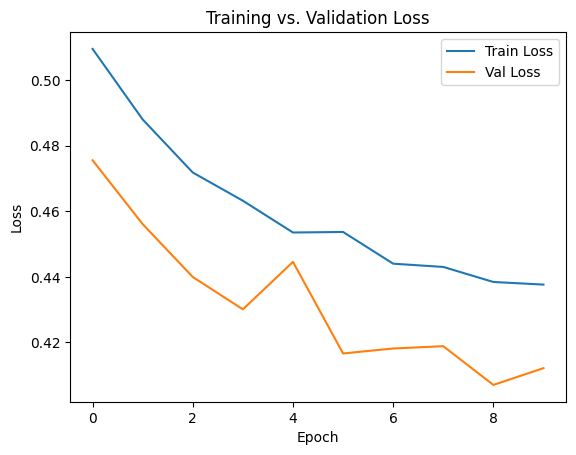

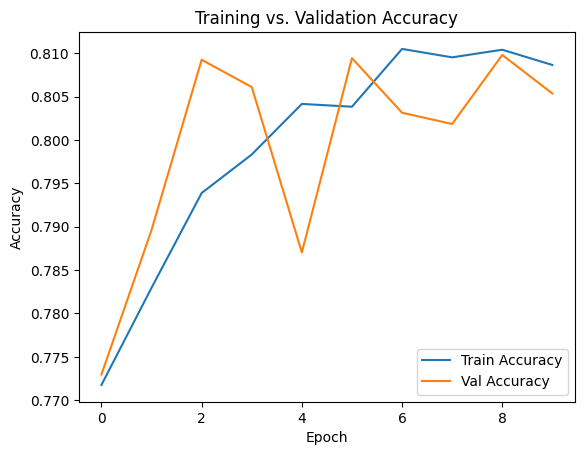

In [15]:
#Visualize Training History
# Plot training and validation loss
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training vs. Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


# Plot training and validation accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Training vs. Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━

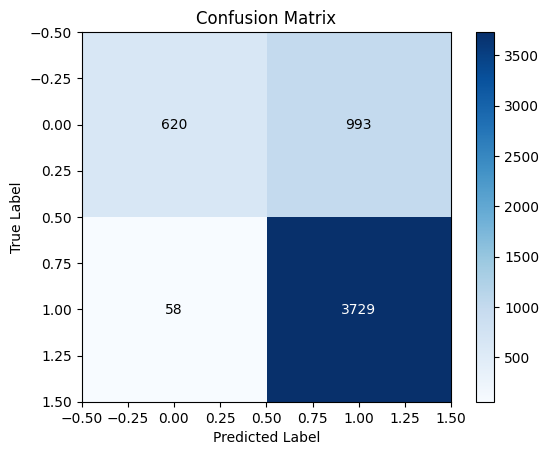

In [16]:
#Evaluate the Model
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

y_true = []
y_pred = []

for images, labels in ds_val:
    preds = model.predict(images)
    preds = np.argmax(preds, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Urban', 'Rural']))

# Plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure()
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.colorbar()

# Annotate the confusion matrix
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 ha='center', va='center',
                 color='white' if cm[i, j] > cm.max()/2. else 'black')
plt.show()


In [17]:
#Save the model
model.save("urban_rural_classifier.h5")
print("Model saved as 'urban_rural_classifier.h5'.")

Model saved as 'urban_rural_classifier.h5'.


In [18]:
#Testing new Images
def load_and_preprocess_image(image_path):
    """
    Load an image file, resize it to IMG_SIZE, and normalize pixel values.
    Returns the image tensor with an added batch dimension.
    """
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return tf.expand_dims(image, axis=0)

In [19]:
#Grad-CAM Visualization
import cv2

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Generate a Grad-CAM heatmap for a given image.
    """
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + tf.keras.backend.epsilon())
    return heatmap.numpy()

def display_gradcam(image_path, model, last_conv_layer_name, alpha=0.4):
    """
    Load an image, compute the Grad-CAM heatmap, and overlay it.
    """
    # Load and preprocess the image
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Generate heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # Load the original image with OpenCV
    orig = cv2.imread(image_path)
    orig = cv2.resize(orig, (IMG_SIZE, IMG_SIZE))
    heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(orig, 1 - alpha, heatmap, alpha, 0)

    plt.figure()
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Grad-CAM")
    plt.show()